# Our primary task is to develop a classification model or generative AI application to distinguish between legitimate (non-spam) and spam messages.

## I propose three approaches to develop our spam detection model.
   1. Traditional machine learning classification models
       *   Logistic Regression
       *   Random Forest
       *   XGBoost
       *   Stacked Classifier

   2. Deep Learning technique
       *   RNNs : LSTM model
    
   3. Large Language Models
       *   RoBERTa : BERT-like LLM
       *   MistralAI : GenAI LLM 7B parameters

## In this notebook, I will explore the RoBERTa approach.
## RoBERTa is a pretrained Large Language model for natural language processing that builds on the success of BERT.
##We used the RoBERTa model and finetuned it further using our data. Finetuning of LLMs require significant amount of RAM. Hence, I have used NVIDIA A100 GPU runtime.

In [ ]:
#Install required libraries
!pip install tqdm
!pip install torch
!pip install transformers

In [ ]:
#Load required models and libraries
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Set seed for reproducibility
seed =0

# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Check for available device (GPU or CPU) for model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize RoBERTa base model for sequence classification
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Set maximum sequence length for tokenization
max_length = 512


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Store our data into a dataframe from a CSV file
ham_and_spam = pd.read_csv("ham_and_spam.csv")
text = ham_and_spam['message'].values
labels = ham_and_spam['flag'].values

In [ ]:
#Now let's create training and testing datasets manually.
#X = ham_and_spam["message"]
#y = ham_and_spam['flag'].values

import pandas as pd
# Split the dataset based on labels
label_0_data = ham_and_spam[ham_and_spam['flag'] == 0]
label_1_data = ham_and_spam[ham_and_spam['flag'] == 1]

# Randomly sample 400 ham points and 200 spam points from each group
sampled_label_0 = label_0_data.sample(n=400, replace=False, random_state=42)
sampled_label_1 = label_1_data.sample(n=200, replace=False, random_state=42)

# Concatenate the sampled data to create the new balanced test dataset
test_dataset = pd.concat([sampled_label_0, sampled_label_1])

#Create training dataset by removing test_dataset from our original dataset
train_dataset = ham_and_spam.merge(test_dataset, indicator=True, how='outer').loc[lambda x: x['_merge'] == 'left_only']

#Create X and Y lables for our datasets
X_train=train_dataset["message"]
y_train=train_dataset["flag"].values
X_test=test_dataset["message"]
y_test=test_dataset["flag"].values

In [ ]:
import torch
from torch.utils.data import Dataset

class SpamMessageDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length):
        self.text = text
        labels = [1 if label == 'spam' else 0 for label in labels]
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # Return the length of the dataset
        return len(self.text)

    def __getitem__(self, idx):
        # Get text and label at the specified index
        text = str(self.text[idx])
        label = self.labels[idx].clone().detach() # Detach label from the computation graph

        # Tokenize the text using the provided tokenizer
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt' # Return PyTorch tensors
        )

        # Retrieve input_ids and attention_mask from the encoding
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Return a dictionary containing input_ids, attention_mask, and label
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }

In [ ]:
# Create an instance of the SpamMessageDataset class for the training data
dataset = SpamMessageDataset(X_train, y_train, tokenizer, max_length=512)

# Determine the sizes for training and validation sets (80% training, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Use random_split to split the dataset into training and validation sets
# random_split takes the dataset and a list specifying sizes for each split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
# Create data loaders for the training and validation sets

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
# Define the optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 10  # Total training steps (epochs * steps per epoch)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

# Learning rate scheduler with warmup for the optimizer
# num_warmup_steps: Number of warmup steps during which the learning rate increases linearly
# num_training_steps: Total number of training steps across all epochs

In [ ]:
# Lists to store training and validation metrics
train_losses = list()
val_losses = list()
val_accuracies = list()
val_precisions = list()
val_recalls = list()
val_f1_scores = list()

In [ ]:
import numpy as np

def compute_metrics(y_true, y_pred, positive_label="spam", negative_label="ham"):
    """
    Compute evaluation metrics for binary classification.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        positive_label (optional): Value representing the positive label. Default is 1.
        negative_label (optional): Value representing the negative label. Default is 0.

    Returns:
        accuracy (float): Accuracy metric.
        precision (float): Precision metric.
        recall (float): Recall metric.
        f1 (float): F1-score metric.
    """
    #y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate accuracy
    accuracy = np.mean(y_true == y_pred)

    # Calculate true positives, false positives, and false negatives
    tp = np.sum(y_true == y_pred)  # Count where true positive (both true and predicted labels are the same)
    fp = np.sum((y_true != y_pred) & (y_pred == positive_label))  # Count where false positive (true label is negative, but predicted as positive)
    fn = np.sum((y_true != y_pred) & (y_pred == negative_label))  # Count where false negative (true label is positive, but predicted as negative)

    # Calculate precision, recall, and F1-score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1


def confusion_matrix(y_true, y_pred):
    """
    Calculates the confusion matrix based on the ground truth and predicted labels.

    Parameters:
        y_true (list): The ground truth labels.
        y_pred (list): The predicted labels.

    Returns:
        list of lists: The confusion matrix.
    """

    # Obtain the unique classes from y_true and y_pred
    classes = list(set(y_true + y_pred))
    classes.sort()

    # Calculate the total number of unique classes
    num_classes = len(classes)

    # Initialize the confusion matrix as a 2D list of zeros
    cm = [[0] * num_classes for _ in range(num_classes)]

    # Iterate over each pair of true and predicted labels
    for true, pred in zip(y_true, y_pred):
        # Find the indices of true and predicted classes in the classes list
        true_idx = classes.index(true)
        pred_idx = classes.index(pred)

        # Increment the corresponding cell in the confusion matrix
        cm[true_idx][pred_idx] += 1

    # Return the confusion matrix
    return cm

### Fine tuning of RoBERTa

In [ ]:
# Finetuning starts here. Requires significant amount of time and memory. DO NOT RUN.
# I have ran it once to fine tune. And I have stored the fine tuned model.
# Loop over epochs (10 in this case)
for epoch in range(10):
  model.train() # Set the model to training mode
  train_loss = 0.0 # Initialize training loss for this epoch

  # Create a progress bar for training batches
  progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{10}', leave=False)

  # Iterate over training batches
  for batch in progress_bar:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']

    optimizer.zero_grad() # Clear gradients

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels) #Forward Pass

    loss = outputs.loss # Calculate the loss
    train_loss += loss.item() # Accumulate the training loss

    loss.backward() # Backpropagation

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip gradients to prevent exploding gradients


    optimizer.step() # Update weights
    scheduler.step() # Update the learning rate scheduler

    # Update the progress bar
    progress_bar.set_postfix({'Training Loss': train_loss / (32 * (progress_bar.n + 1))})

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Evaluation on the validation set
    model.eval()
    val_loss = 0.0
    total_val_loss = 0.0
    val_accuracy = 0.0
    val_precision = 0.0
    val_recall = 0.0

    with torch.no_grad():
      y_true = []
      y_pred = []

      # Iterate over validation batches
      for batch in val_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss # Calculate the loss
        logits = outputs.logits
        total_val_loss += loss.item() # Calculate the loss

        predictions = torch.argmax(logits, dim=1)

        y_true.extend(labels.tolist())
        y_pred.extend(predictions.tolist())

      # Calculate and store evaluation metrics (accuracy, precision, recall, F1-score)
      val_loss = total_val_loss / len(val_loader)
      val_losses.append(val_loss)
      val_accuracy, val_precision, val_recall, val_f1 = compute_metrics(y_true, y_pred, 1, 0)
      val_precisions.append(val_precision)
      val_recalls.append(val_recall)
      val_f1_scores.append(val_f1)
      val_accuracies.append(val_accuracy)

        # Print the metrics and confusion matrix for each epoch
    print(f'Epoch {epoch + 1}/{32} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f} - Val Precision: {val_precision:.4f} - Val Recall: {val_recall:.4f}')

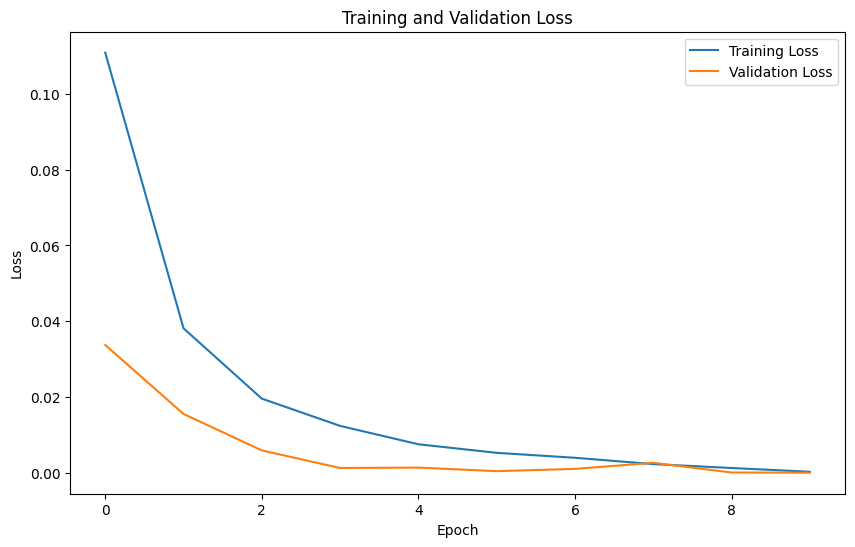

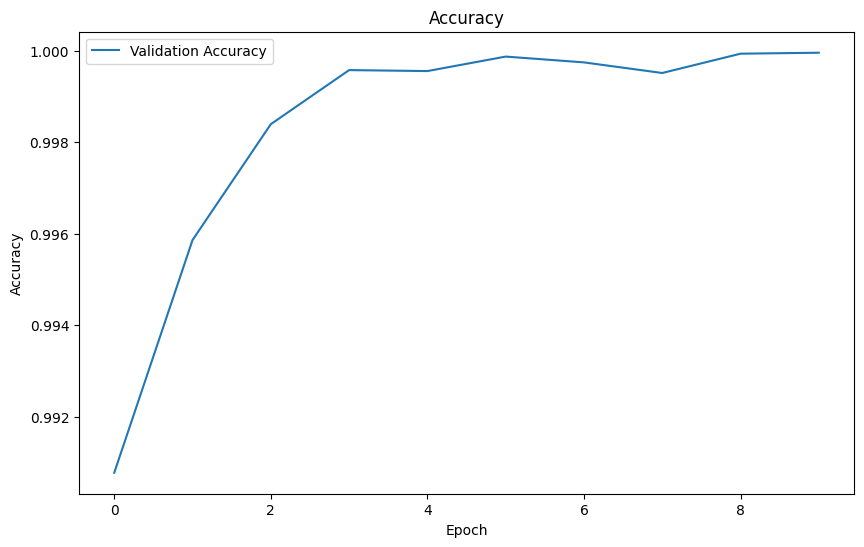

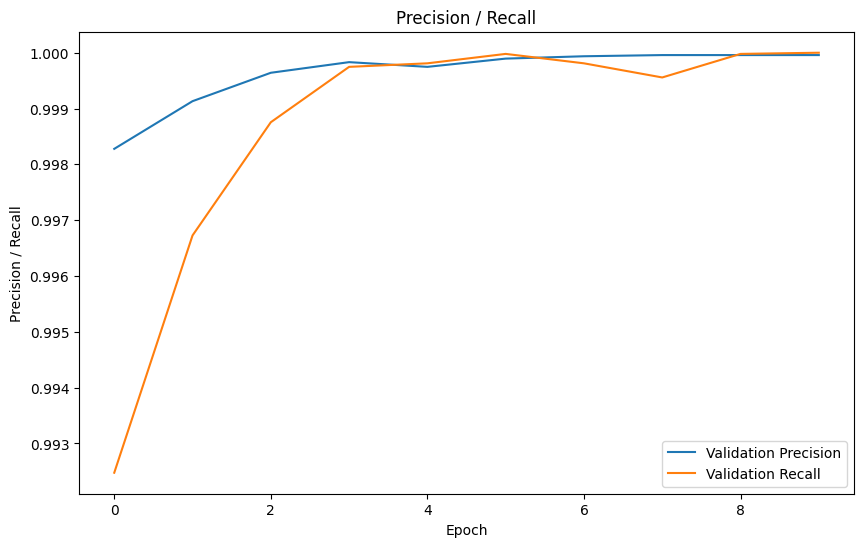

In [ ]:
"""
save_list_to_file(train_losses, "train_losses.txt")
save_list_to_file(val_losses, "val_losses.txt")
save_list_to_file(val_accuracies, "val_accuracies.txt")
save_list_to_file(val_precisions, "val_precisions.txt")
save_list_to_file(val_recalls, "val_recalls.txt")
save_list_to_file(val_f1_scores, "val_f1_scores.txt")
"""
def read_list_from_file(filename):
    with open(filename, 'r') as file:
        data = file.readlines()
        # Assuming each line in the file contains one element of the list
        data = [float(value.strip()) for value in data]  # Adjust the type conversion as needed
    return data

train_losses = read_list_from_file("train_losses.txt")
val_losses = read_list_from_file("val_losses.txt")
val_accuracies = read_list_from_file("val_accuracies.txt")
val_precisions = read_list_from_file("val_precisions.txt")
val_recalls = read_list_from_file("val_recalls.txt")
val_f1_scores = read_list_from_file("val_f1_scores.txt")
# Plots
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_precisions, label='Validation Precision')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Precision / Recall')
plt.title('Precision / Recall')
plt.legend()
plt.show()

In [ ]:
#Save the fine tuned model
model.save_pretrained("trained_model")
tokenizer.save_pretrained("trained_model")

('trained_model/tokenizer_config.json',
 'trained_model/special_tokens_map.json',
 'trained_model/vocab.json',
 'trained_model/merges.txt',
 'trained_model/added_tokens.json')

### Load the fine-tuned model and evaluate on the test data

In [ ]:

#Connect to google drive
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#I have stored my finetuned RoBERTa model to both google drive and huggingface model Hub.
#I am loading it from google drive so that I won't need to download it.
seed =0
tokenizer = RobertaTokenizer.from_pretrained("/content/drive/MyDrive/roberta_spam")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained("/content/drive/MyDrive/roberta_spam", num_labels=2)
max_length = 512

In [ ]:
#Prepare test data
X_test=test_dataset["message"].tolist()
y_test=test_dataset["flag"].values

In [ ]:
def preprocess(text):
  # Tokenize and encode the text using the tokenizer
  inputs = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=512,
      padding="longest",
      truncation=True,
      return_tensors="pt" # Return PyTorch tensors
  )
  return inputs["input_ids"], inputs["attention_mask"] # Return input_ids and attention_mask

# Preprocess each text in the X_test dataset using the preprocess function
inputs = [preprocess(text) for text in X_test]

In [ ]:
predictions = []

# Disable gradient calculations during inference
with torch.no_grad():
  # Iterate through preprocessed inputs (input_ids, attention_mask)
  for input_ids, attention_mask in inputs:
      # Get model predictions for the input
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

      logits = outputs.logits

      # Predict the label by selecting the class with the highest probability
      predicted_label = torch.argmax(logits, dim=1).item()
      if predicted_label == 0:
          predictions.append(0)
      else:
          predictions.append(1)

# compute evaluation metrics
accuracy, precision, recall, f1 = compute_metrics(y_test, predictions)


<ipython-input-25-cf4aeccc4280>:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  fp = np.sum((y_true != y_pred) & (y_pred == positive_label))  # Count where false positive (true label is negative, but predicted as positive)
<ipython-input-25-cf4aeccc4280>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  fn = np.sum((y_true != y_pred) & (y_pred == negative_label))  # Count where false negative (true label is positive, but predicted as negative)


In [ ]:
cm = confusion_matrix(y_test, predictions)
labels_sorted = sorted(set(labels))

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
cm

Accuracy: 0.9967
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


[[400, 0, 0], [2, 198, 0], [0, 0, 0]]

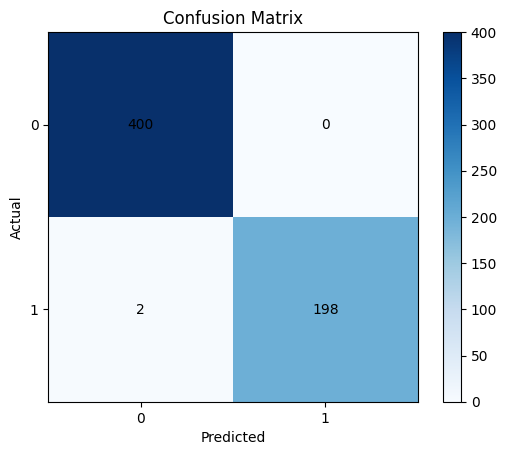

In [ ]:
conf_matrix = np.array([[400, 0], [2, 198]])

plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

# Add labels for each cell
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(np.arange(conf_matrix.shape[1]))
plt.yticks(np.arange(conf_matrix.shape[0]))
plt.show()

#### Finetuned RoBERTa is performing very well on the test dataset. RoBERTa LLM outperformed all traditional machine learning models.